In [1]:
# import required modules
import numpy as np
import pandas as pd
from collections import Counter
import statistics

import datetime
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# import data
allFactors = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/geo/Metadata_Matrix2.csv', low_memory = False)
allFactors.head()

,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases
0,PMC3879970,SRP008153,GSE32074,GEO,2013-11-18,2011-11-21,Aedes aegypti,high-throughput sequencing,RNA-Seq,NaN,NaN
1,PMC3879970,SRP003874,GSE24872,GEO,2013-11-18,2011-03-01,Aedes aegypti,high-throughput sequencing,RNA-Seq,NaN,NaN
2,PMC3879970,SRP009679,GSE34319,GEO,2013-11-18,2012-08-15,Aedes aegypti,high-throughput sequencing,RNA-Seq,NaN,NaN
3,PMC3893718,GSE24843,E-GEOD-24843,NaN,2013-08-08,NaN,NaN,NaN,NaN,NaN,NaN
4,PMC3921077,SRR207100,GSE29278,GEO,2014-01-20,"Jul 01, 2012",Mus musculus,NaN,NaN,NaN,NaN


In [5]:
# add a column with the total use count of each converted_accession ID
justAcc = allFactors.loc[:, ['pmc_ID', 'converted_accession']].drop_duplicates()
justAcc.head()

,pmc_ID,converted_accession
0,PMC3879970,GSE32074
1,PMC3879970,GSE24872
2,PMC3879970,GSE34319
3,PMC3893718,E-GEOD-24843
4,PMC3921077,GSE29278


In [6]:
# count reuse
rc = Counter(justAcc['converted_accession'])
reuse_counts = pd.DataFrame.from_dict(rc, orient = 'index').reset_index()
reuse_counts.columns = ['converted_accession', 'total_use_count']
reuse_counts.head()

,converted_accession,total_use_count
0,GSE32074,2
1,GSE24872,3
2,GSE34319,4
3,E-GEOD-24843,5
4,GSE29278,9


In [7]:
# merge reuse counts onto table
allFactors = pd.merge(allFactors, reuse_counts, how = 'left', on = 'converted_accession')
allFactors.head()

,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,total_use_count
0,PMC3879970,SRP008153,GSE32074,GEO,2013-11-18,2011-11-21,Aedes aegypti,high-throughput sequencing,RNA-Seq,NaN,NaN,2
1,PMC3879970,SRP003874,GSE24872,GEO,2013-11-18,2011-03-01,Aedes aegypti,high-throughput sequencing,RNA-Seq,NaN,NaN,3
2,PMC3879970,SRP009679,GSE34319,GEO,2013-11-18,2012-08-15,Aedes aegypti,high-throughput sequencing,RNA-Seq,NaN,NaN,4
3,PMC3893718,GSE24843,E-GEOD-24843,NaN,2013-08-08,NaN,NaN,NaN,NaN,NaN,NaN,5
4,PMC3921077,SRR207100,GSE29278,GEO,2014-01-20,"Jul 01, 2012",Mus musculus,NaN,NaN,NaN,NaN,9


In [11]:
import pandas as pd
from datetime import datetime

# Function to validate date format
def is_valid_date(date_str, date_format='%Y-%m-%d'):
    try:
        datetime.strptime(date_str, date_format)
        return True
    except ValueError:
        return False

# Read the CSV file
df = allFactors
#output_file = 'path/to/your/output.csv'
#df = pd.read_csv(input_file)

# Replace invalid dates with NaN
df['pmc_date'] = df['pmc_date'].apply(lambda x: x if is_valid_date(str(x)) else pd.NA)
df['repository_date'] = df['repository_date'].apply(lambda x: x if is_valid_date(str(x)) else pd.NA)

# Fill blank cells with the corresponding value from the other column
df['pmc_date'] = df['pmc_date'].fillna(df['repository_date'])
df['repository_date'] = df['repository_date'].fillna(df['pmc_date'])

# Save the cleaned DataFrame to a new CSV file
#df.to_csv(output_file, index=False)

In [13]:
allFactors = df

In [21]:
#allFactors['repository_date'] = allFactors['repository_date'].str.strip()
allFactors['repository_date'] = pd.to_datetime(allFactors['repository_date'], format='%Y-%m-%d', errors='coerce')

# Create today's date column and convert to datetime
allFactors['today'] = pd.to_datetime(date.today().strftime('%Y-%m-%d'), format='%Y-%m-%d')

# Create timedelta objects representing amount of time public in YEARS
allFactors['time_public'] = allFactors['today'] - allFactors['repository_date']

# Ensure 'time_public' is calculated only for valid dates
valid_time_public = allFactors['time_public'].notna()
allFactors.loc[valid_time_public, 'time_public'] = allFactors.loc[valid_time_public, 'time_public'].dt.days / 365

# normalize reuse count by years public
allFactors['reuse_count'] = (allFactors['total_use_count'] - 1)
allFactors['norm_reuse_count'] = allFactors['reuse_count'] / allFactors['time_public']
allFactors = allFactors.drop(labels = ['total_use_count'], axis = 1)
allFactors.head()


,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,today,time_public,reuse_count,norm_reuse_count
0,PMC3879970,SRP008153,GSE32074,GEO,2013-11-18,2011-11-21,Aedes aegypti,high-throughput sequencing,RNA-Seq,NaN,NaN,2024-05-24,12.515068,1,0.079904
1,PMC3879970,SRP003874,GSE24872,GEO,2013-11-18,2011-03-01,Aedes aegypti,high-throughput sequencing,RNA-Seq,NaN,NaN,2024-05-24,13.241096,2,0.151045
2,PMC3879970,SRP009679,GSE34319,GEO,2013-11-18,2012-08-15,Aedes aegypti,high-throughput sequencing,RNA-Seq,NaN,NaN,2024-05-24,11.780822,3,0.254651
3,PMC3893718,GSE24843,E-GEOD-24843,NaN,2013-08-08,2013-08-08,NaN,NaN,NaN,NaN,NaN,2024-05-24,10.8,4,0.37037
4,PMC3921077,SRR207100,GSE29278,GEO,2014-01-20,2014-01-20,Mus musculus,NaN,NaN,NaN,NaN,2024-05-24,10.347945,8,0.7731


In [ ]:
# normalize reuse count by amount of time public

# convert repository upload dates and today's date to datetime objects
#allFactors.loc[:,'repository_date'] = allFactors['repository_date'].replace({' ':''})
#allFactors.loc[:,'repository_date'] = pd.to_datetime(allFactors['repository_date'], format = '%Y-%m-%d',  errors='coerce')
#allFactors['today'] = date.today().strftime('%Y-%m-%d')
#allFactors['today'] = pd.to_datetime(allFactors['today'], format = '%Y-%m-%d' ,  errors='coerce')

# create timedelta objects representing amount of time public in YEARS
#allFactors['time_public'] = allFactors['today'] - allFactors['repository_date']
#allFactors['time_public'] = allFactors['time_public'].dt.days / 365

# normalize reuse count by years public
#allFactors['reuse_count'] = (allFactors['total_use_count'] - 1)
#allFactors['norm_reuse_count'] = allFactors['reuse_count'] / allFactors['time_public']
#allFactors = allFactors.drop(labels = ['total_use_count'], axis = 1)
#allFactors.head()

In [25]:
# Convert pmc_date to datetime, handle errors by converting invalid dates to NaT
allFactors['pmc_date'] = pd.to_datetime(allFactors['pmc_date'], format='%Y-%m-%d', errors='coerce')

# Take each converted accession along with the first date it appears in a paper
justPap = allFactors.loc[:, ['converted_accession', 'pmc_date']].drop_duplicates()

# Ensure all pmc_date values are datetime objects
justPap['pmc_date'] = pd.to_datetime(justPap['pmc_date'], errors='coerce')

# Group by converted_accession and get the minimum pmc_date for each group
justPap = justPap.groupby('converted_accession', as_index=False).agg({'pmc_date': 'min'})
justPap = justPap.rename(columns = {'pmc_date':'min_pmc_date'})

# label all of the usages of these datasets on these dates with a 'G' (generators)
justPap.loc[:,'reuse_role'] = 'G'
justPap.head()

,converted_accession,min_pmc_date,reuse_role
0,DRP000001,2010-01-22,G
1,DRP000002,2011-08-25,G
2,DRP000009,2012-01-27,G
3,DRP000010,2010-04-27,G
4,DRP000017,2011-10-09,G


In [ ]:
# Tag each paper as either a generator or a reuser

# take each converted accession along with the first date it appears in a paper
#justPap = allFactors.loc[:, ['converted_accession', 'pmc_date']].drop_duplicates()
#justPap = justPap.groupby('converted_accession', as_index = False).agg({'pmc_date': 'min'})
#justPap = justPap.rename(columns = {'pmc_date':'min_pmc_date'})

# label all of the usages of these datasets on these dates with a 'G' (generators)
#justPap.loc[:,'reuse_role'] = 'G'
#justPap.head()

In [27]:
# merge these back onto the original table, matching dates back to papers
allFactors = pd.merge(allFactors, justPap, how = 'left',
                      left_on = ['converted_accession', 'pmc_date'],
                      right_on = ['converted_accession', 'min_pmc_date'])

# label every usage of a dataset that isn't 'G' (generator) as 'R' (reuser)
allFactors['allR'] = 'R'
allFactors['reuse_role'] = allFactors['reuse_role'].fillna(allFactors['allR'])

# drop redundant columns
allFactors = allFactors.drop(labels = ['min_pmc_date', 'allR'], axis = 1)

In [28]:
allFactors.head()

,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,today,time_public,reuse_count,norm_reuse_count,reuse_role
0,PMC3879970,SRP008153,GSE32074,GEO,2013-11-18,2011-11-21,Aedes aegypti,high-throughput sequencing,RNA-Seq,NaN,NaN,2024-05-24,12.515068,1,0.079904,R
1,PMC3879970,SRP003874,GSE24872,GEO,2013-11-18,2011-03-01,Aedes aegypti,high-throughput sequencing,RNA-Seq,NaN,NaN,2024-05-24,13.241096,2,0.151045,R
2,PMC3879970,SRP009679,GSE34319,GEO,2013-11-18,2012-08-15,Aedes aegypti,high-throughput sequencing,RNA-Seq,NaN,NaN,2024-05-24,11.780822,3,0.254651,G
3,PMC3893718,GSE24843,E-GEOD-24843,NaN,2013-08-08,2013-08-08,NaN,NaN,NaN,NaN,NaN,2024-05-24,10.8,4,0.37037,G
4,PMC3921077,SRR207100,GSE29278,GEO,2014-01-20,2014-01-20,Mus musculus,NaN,NaN,NaN,NaN,2024-05-24,10.347945,8,0.7731,R


### perform QC

In [29]:
# cut out whitespace
allFactors.loc[:,'pmc_date'] = allFactors['pmc_date'].replace({' ':''})

# take slice of what we need from allFactors
gens = allFactors.loc[allFactors['reuse_role'] == 'G', :]

In [30]:
gens.head()

,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,today,time_public,reuse_count,norm_reuse_count,reuse_role
2,PMC3879970,SRP009679,GSE34319,GEO,2013-11-18,2012-08-15,Aedes aegypti,high-throughput sequencing,RNA-Seq,NaN,NaN,2024-05-24,11.780822,3,0.254651,G
3,PMC3893718,GSE24843,E-GEOD-24843,NaN,2013-08-08,2013-08-08,NaN,NaN,NaN,NaN,NaN,2024-05-24,10.8,4,0.37037,G
8,PMC7116321,GSE69149,E-GEOD-69149,NaN,2020-05-01,2020-05-01,NaN,NaN,NaN,NaN,NaN,2024-05-24,4.065753,1,0.245957,G
15,PMC7612297,SRP117215,GSE103672,GEO,2022-01-27,2022-01-27,Homo sapiens,NaN,NaN,NaN,NaN,2024-05-24,2.323288,5,2.152123,G
20,PMC7126238,SRX2924018,GSE100099,GEO,2020-05-04,2020-05-04,Homo sapiens,NaN,NaN,NaN,NaN,2024-05-24,4.057534,2,0.49291,G


In [31]:
# convert to date objects
gens.loc[:,'pmc_date'] = pd.to_datetime(gens['pmc_date'], format = '%Y-%m-%d', errors = 'coerce')
gens.loc[:,'repository_date'] = pd.to_datetime(gens['repository_date'], format = '%Y-%m-%d')

In [32]:
# subtract columns of date objects, creating a column of timedelta objects
gens.loc[:,'pub_delay'] = gens['pmc_date'] - gens['repository_date']
gens = gens.dropna(subset = ['pub_delay'])

<ipython-input-32-cc2437e535a6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gens.loc[:,'pub_delay'] = gens['pmc_date'] - gens['repository_date']


In [33]:
# convert timedeltas back to integers
gens.loc[:,'pub_delay'] = gens['pub_delay'].dt.days
gens = gens.sort_values(by = 'pub_delay', ascending = False)
gens

,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,today,time_public,reuse_count,norm_reuse_count,reuse_role,pub_delay
327273,PMC9317271,GSM501,GSE6;GSE3479,GEO,2022-07-13,2001-07-25,Helicobacter pylori,spotted DNA/cDNA,Expression_Array,NaN,NaN,2024-05-24,22.846575,3,0.131311,G,7658
337525,PMC9502317,GSM601,GSE11;GSE12,GEO,2022-09-13,2001-11-21,Mus musculus,in situ oligonucleotide,Expression_Array,NaN,NaN,2024-05-24,22.520548,0,0.0,G,7601
337522,PMC9502317,GSM605,GSE11;GSE15,GEO,2022-09-13,2001-11-21,Mus musculus,in situ oligonucleotide,Expression_Array,NaN,NaN,2024-05-24,22.520548,0,0.0,G,7601
337532,PMC9502317,GSM604,GSE11;GSE15,GEO,2022-09-13,2001-11-21,Mus musculus,in situ oligonucleotide,Expression_Array,NaN,NaN,2024-05-24,22.520548,0,0.0,G,7601
337526,PMC9502317,GSM602,GSE11;GSE12,GEO,2022-09-13,2001-11-21,Mus musculus,in situ oligonucleotide,Expression_Array,NaN,NaN,2024-05-24,22.520548,0,0.0,G,7601
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59291,PMC4676435,ERP140034,ERP140034,SRA,2014-09-01,2023-09-27,Drosophila melanogaster,NextSeq 500,ssRNA-seq,158.0,3.583212e+10,2024-05-24,0.657534,0,0.0,G,-3313
393039,PMC3968321,PRJNA208535,SRP026107,SRA,2013-12-02,2023-05-01,human vaginal metagenome,Illumina HiSeq 4000,WGS,291.0,1.116377e+09,2024-05-24,1.065753,11,10.321337,G,-3437
393040,PMC3968321,SRP026107,SRP026107,SRA,2013-12-02,2023-05-01,human vaginal metagenome,Illumina HiSeq 4000,WGS,291.0,1.116377e+09,2024-05-24,1.065753,11,10.321337,G,-3437
393041,PMC3968321,SRA091234,SRP026107,SRA,2013-12-02,2023-05-01,human vaginal metagenome,Illumina HiSeq 4000,WGS,291.0,1.116377e+09,2024-05-24,1.065753,11,10.321337,G,-3437


<ipython-input-34-c350a0c88a5b>:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(gens['pub_delay'], ax = ax)


<Axes: xlabel='pub_delay', ylabel='Density'>

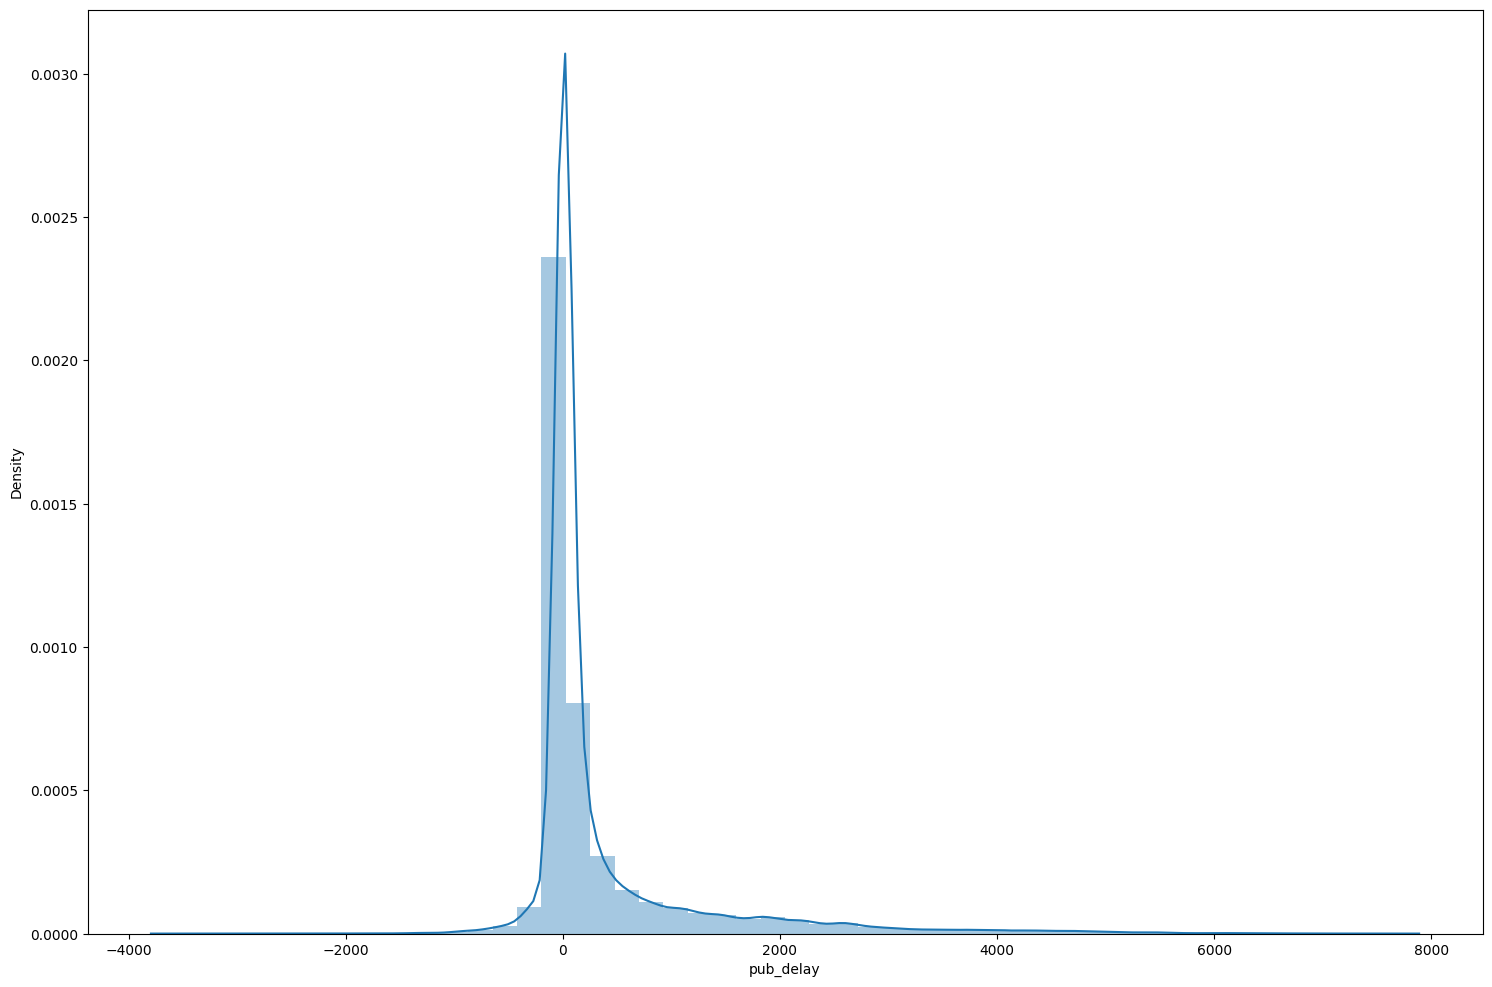

In [34]:
# plot timedelta distribution
fig_dims = (18,12)
fig, ax = plt.subplots(figsize=fig_dims)
sns.distplot(gens['pub_delay'], ax = ax)

In [35]:
# select only papers in a reasonable timedelta window

DELAY_MIN = -270
DELAY_MAX = 270

gens_filtered = gens.loc[gens['pub_delay'] <= DELAY_MAX, :].loc[gens['pub_delay'] >= DELAY_MIN, :]
gens_filtered.head()

,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,today,time_public,reuse_count,norm_reuse_count,reuse_role,pub_delay
356310,PMC9484756,PRJNA774891,SRP343296,SRA,2022-08-02,2021-11-05,human gut metagenome,Illumina MiSeq,AMPLICON,550.0,2.607000e+07,2024-05-24,2.550685,0,0.0,G,270
408800,PMC1584276,GSE2534,GSE2534,GEO,2006-09-29,2006-01-02,Mus musculus,in situ oligonucleotide,Expression_Array,NaN,NaN,2024-05-24,18.40274,0,0.0,G,270
60562,PMC4561489,SRS779760,SRP050557,SRA,2015-09-01,2014-12-05,Mus musculus,Illumina HiSeq 2000,DNase-Hypersensitivity,189.0,7.697183e+09,2024-05-24,9.473973,0,0.0,G,270
232910,PMC4005674,GSE37275,GSE37275,GEO,2014-04-20,2013-07-24,Mus musculus,high-throughput sequencing,RNA-Seq,NaN,NaN,2024-05-24,10.841096,2,0.184483,G,270
125614,PMC6161849,PRJNA376485,SRP100609,SRA,2018-09-28,2018-01-01,Brachypodium distachyon,Illumina HiSeq 2500,RNA-Seq,202.0,1.327575e+10,2024-05-24,6.39726,0,0.0,G,270


In [36]:
# select random papers inside/outside threshold for QC analysis
import random

# gens_filtered are inside threshold already
# get papers outside threshold, but within 365 days

DELAY_EDGE = 365

gens_aboveThresh = gens.loc[gens['pub_delay'] >= DELAY_MAX, :].loc[gens['pub_delay'] <= DELAY_EDGE]
gens_aboveThresh = gens_aboveThresh.loc[gens_aboveThresh['repository'] == "GEO", :]
gens_belowThresh = gens.loc[gens['pub_delay'] <= DELAY_MIN, :].loc[gens['pub_delay'] >= -DELAY_EDGE]
gens_belowThresh = gens_belowThresh.loc[gens_belowThresh['repository'] == "GEO", :]
gens_insideThresh = gens_filtered.loc[gens_filtered['repository'] == "GEO", :]

num_papers = 50
half_papers = int(num_papers / 2)

# take random samples inside, above, and below threshold
rand_in = pd.DataFrame(random.sample(gens_insideThresh['pmc_ID'].tolist(), num_papers))
rand_in.columns = ['pmc_ID']
rand_ab = pd.DataFrame(random.sample(gens_aboveThresh['pmc_ID'].tolist(), half_papers))
rand_ab.columns = ['pmc_ID']
rand_be = pd.DataFrame(random.sample(gens_belowThresh['pmc_ID'].tolist(), half_papers))
rand_be.columns = ['pmc_ID']

# match accessions to papers to make manual work easier
r_in = pd.merge(rand_in, gens_insideThresh[['pmc_ID', 'accession']], on = 'pmc_ID', how = 'left').drop_duplicates()
r_in['real_introducer'] = np.NaN
r_ab = pd.merge(rand_ab, gens_aboveThresh[['pmc_ID', 'accession']], on = 'pmc_ID', how = 'left').drop_duplicates()
r_be = pd.merge(rand_be, gens_belowThresh[['pmc_ID', 'accession']], on = 'pmc_ID', how = 'left').drop_duplicates()
r_out = pd.concat([r_ab, r_be])
r_out['real_introducer'] = np.NaN

# save incomplete files to csv
r_in.to_csv('/content/drive/MyDrive/Colab Notebooks/geo/randomIntroducers_INSIDE.csv', index = False)
r_out.to_csv('/content/drive/MyDrive/Colab Notebooks/geo/randomIntroducers_OUTSIDE.csv', index = False)

In [39]:
# fill the column "real_introducer" manully, and rename the files "randomIntroducers_INSIDE_270days_filledin.csv" and "randomIntroducers_OUTSIDE_270days_filledin.csv"
# validate each of these randomly selected paper-dataset relationships

# import the manually produced data (now complete files)
rinf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/geo/randomIntroducers_INSIDE_270days_filledin.csv').dropna()
routf = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/geo/randomIntroducers_OUTSIDE_270days_filledin.csv').dropna()

# create a true positive column
# true positive means PMC_ID == REAL_INTRODUCER
rinf['TP'] = np.where(rinf['pmc_ID'] == rinf['real_introducer'], True, False)
routf['TN'] = np.where(routf['pmc_ID'] != routf['real_introducer'], True, False)

# reduce the tables to just PMC_ID and TP/TN
rinf = rinf[['pmc_ID', 'TP']].drop_duplicates()
routf = routf[['pmc_ID', 'TN']].drop_duplicates()

tp = statistics.mean(rinf['TP'])
tn = statistics.mean(routf['TN'])

print('True Positive rate (inside threshold): ' + str(tp))
print('True Negative rate (outside threshold, inside year): ' + str(tn))

NameError: name 'rinf' is not defined

In [40]:
not_gens = allFactors.loc[allFactors['reuse_role'] != 'G', :]
filtered_matrix = pd.concat(objs = [gens_filtered, not_gens], ignore_index = True, sort = False)
filtered_matrix

,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,today,time_public,reuse_count,norm_reuse_count,reuse_role,pub_delay
0,PMC9484756,PRJNA774891,SRP343296,SRA,2022-08-02,2021-11-05,human gut metagenome,Illumina MiSeq,AMPLICON,550.0,2.607000e+07,2024-05-24,2.550685,0,0.0,G,270.0
1,PMC1584276,GSE2534,GSE2534,GEO,2006-09-29,2006-01-02,Mus musculus,in situ oligonucleotide,Expression_Array,NaN,NaN,2024-05-24,18.40274,0,0.0,G,270.0
2,PMC4561489,SRS779760,SRP050557,SRA,2015-09-01,2014-12-05,Mus musculus,Illumina HiSeq 2000,DNase-Hypersensitivity,189.0,7.697183e+09,2024-05-24,9.473973,0,0.0,G,270.0
3,PMC4005674,GSE37275,GSE37275,GEO,2014-04-20,2013-07-24,Mus musculus,high-throughput sequencing,RNA-Seq,NaN,NaN,2024-05-24,10.841096,2,0.184483,G,270.0
4,PMC6161849,PRJNA376485,SRP100609,SRA,2018-09-28,2018-01-01,Brachypodium distachyon,Illumina HiSeq 2500,RNA-Seq,202.0,1.327575e+10,2024-05-24,6.39726,0,0.0,G,270.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350665,PMC1544358,GDS531,GSE755,GEO,2006-07-26,2006-07-26,Homo sapiens,NaN,NaN,NaN,NaN,2024-05-24,17.841096,6,0.336302,R,NaN
350666,PMC1797053,GSE3744,GSE3744,GEO,2007-02-05,2006-02-09,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,2024-05-24,18.29863,77,4.207965,R,NaN
350667,PMC1635568,GDS232,GSE468,GEO,2006-11-01,2003-02-22,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,2024-05-24,21.265753,4,0.188096,R,NaN
350668,PMC1564424,GSE5405,GSE5405,GEO,2006-09-15,2006-09-05,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,2024-05-24,17.728767,1,0.056406,R,NaN


In [41]:
lsc = Counter(filtered_matrix.loc[filtered_matrix['repository'] == "SRA", ]["library_strategy"])
lsc_df = pd.DataFrame.from_dict(lsc, orient = 'index').reset_index()
sraLS = list(lsc_df["index"])
sraLS.remove("RNA-Seq")
sraLS

['AMPLICON',
 'DNase-Hypersensitivity',
 'WGS',
 'miRNA-Seq',
 'WXS',
 'RAD-Seq',
 'Hi-C',
 'OTHER',
 'Bisulfite-Seq',
 'Targeted-Capture',
 'ChIP-Seq',
 'FL-cDNA',
 'WGA',
 'EST',
 'ATAC-seq',
 'WCS',
 'Tn-Seq',
 'CLONE',
 'POOLCLONE',
 'Synthetic-Long-Read',
 'ncRNA-Seq',
 'other',
 'RIP-Seq',
 'MNase-Seq',
 'CLONEEND',
 'MeDIP-Seq',
 'MRE-Seq',
 'MBD-Seq',
 'SELEX',
 'FINISHING',
 'ChIA-PET',
 'ssRNA-seq',
 'Tethered Chromatin Conformation Capture',
 'FAIRE-seq',
 'CTS',
 'VALIDATION',
 'ChIP']

In [42]:
# add a column for "class"... separating GEO/SRA distinction into:
# (1) GEO gene expression
# (2) RNA-seq (GEO and SRA)
# (3) SRA other omics technologies

key = {"repository": ["GEO", "GEO", "SRA"] + ["SRA"]*(len(sraLS)),
       "library_strategy": ["Expression_Array", "RNA-Seq", "RNA-Seq"] + sraLS,
      "class": ["GEO_expr", "RNA-Seq", "RNA-Seq"] + ["SRA_other"]*(len(sraLS))}
key = pd.DataFrame(key)
key

,repository,library_strategy,class
0,GEO,Expression_Array,GEO_expr
1,GEO,RNA-Seq,RNA-Seq
2,SRA,RNA-Seq,RNA-Seq
3,SRA,AMPLICON,SRA_other
4,SRA,DNase-Hypersensitivity,SRA_other
5,SRA,WGS,SRA_other
6,SRA,miRNA-Seq,SRA_other
7,SRA,WXS,SRA_other
8,SRA,RAD-Seq,SRA_other
9,SRA,Hi-C,SRA_other


In [43]:
filtered_matrix = pd.merge(filtered_matrix, key, how = 'left', on = ['repository', 'library_strategy'])
filtered_matrix

,pmc_ID,accession,converted_accession,repository,pmc_date,repository_date,species,hardware,library_strategy,sraAvg_length,sraBases,today,time_public,reuse_count,norm_reuse_count,reuse_role,pub_delay,class
0,PMC9484756,PRJNA774891,SRP343296,SRA,2022-08-02,2021-11-05,human gut metagenome,Illumina MiSeq,AMPLICON,550.0,2.607000e+07,2024-05-24,2.550685,0,0.0,G,270.0,SRA_other
1,PMC1584276,GSE2534,GSE2534,GEO,2006-09-29,2006-01-02,Mus musculus,in situ oligonucleotide,Expression_Array,NaN,NaN,2024-05-24,18.40274,0,0.0,G,270.0,GEO_expr
2,PMC4561489,SRS779760,SRP050557,SRA,2015-09-01,2014-12-05,Mus musculus,Illumina HiSeq 2000,DNase-Hypersensitivity,189.0,7.697183e+09,2024-05-24,9.473973,0,0.0,G,270.0,SRA_other
3,PMC4005674,GSE37275,GSE37275,GEO,2014-04-20,2013-07-24,Mus musculus,high-throughput sequencing,RNA-Seq,NaN,NaN,2024-05-24,10.841096,2,0.184483,G,270.0,RNA-Seq
4,PMC6161849,PRJNA376485,SRP100609,SRA,2018-09-28,2018-01-01,Brachypodium distachyon,Illumina HiSeq 2500,RNA-Seq,202.0,1.327575e+10,2024-05-24,6.39726,0,0.0,G,270.0,RNA-Seq
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
350665,PMC1544358,GDS531,GSE755,GEO,2006-07-26,2006-07-26,Homo sapiens,NaN,NaN,NaN,NaN,2024-05-24,17.841096,6,0.336302,R,NaN,NaN
350666,PMC1797053,GSE3744,GSE3744,GEO,2007-02-05,2006-02-09,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,2024-05-24,18.29863,77,4.207965,R,NaN,GEO_expr
350667,PMC1635568,GDS232,GSE468,GEO,2006-11-01,2003-02-22,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,2024-05-24,21.265753,4,0.188096,R,NaN,GEO_expr
350668,PMC1564424,GSE5405,GSE5405,GEO,2006-09-15,2006-09-05,Homo sapiens,in situ oligonucleotide,Expression_Array,NaN,NaN,2024-05-24,17.728767,1,0.056406,R,NaN,GEO_expr


In [44]:
# what are the SRA library strategies?
lc = Counter(filtered_matrix.loc[filtered_matrix['repository'] == 'SRA', :]['library_strategy'])
libCntr = pd.DataFrame.from_dict(lc, orient = 'index')
libCntr.to_csv('/content/drive/MyDrive/Colab Notebooks/geo/SRAlibraryStrategies.csv', header = False)

In [45]:
# how much data coverage do we get when using the class column?
Counter(filtered_matrix['class'])

Counter({'SRA_other': 76196, 'GEO_expr': 82285, 'RNA-Seq': 39975, nan: 152214})

In [46]:
filtered_matrix.to_csv('/content/drive/MyDrive/Colab Notebooks/geo/metadataMatrix_filtered.csv', index = False)